<h1>Detecting deforestation from satellite images</h1>

This Notebook is used to train a ResNet-50 model on Amazon Planet Dataset (MultiLabel Classification Problem)
Used Fast AI for eaiser training and inference rather than PyTorch or Tensorflow.

Download data from here: https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/data

Inspired by https://medium.com/@andrecnf

In [3]:
!pip install Pillow==8.2.0

ERROR: Could not find a version that satisfies the requirement Pillow==8.2.0 (from versions: none)
ERROR: No matching distribution found for Pillow==8.2.0
You should consider upgrading via the 'D:\Anaconda\python.exe -m pip install --upgrade pip' command.


In [4]:
#How to unzip .7z archives
#import py7zr
#archive = py7zr.SevenZipFile('/.7z', mode='r')
#archive.extractall(path="/path")
#archive.close()

<h2>Loading and Visualizing Dataset</h2>

In [5]:
from fastai.vision.all import *
path = Path(r'D:\python_projects\Deforestation\input')

In [6]:
path.ls()

(#5) [Path('D:/python_projects/Deforestation/input/sample_submission.csv'),Path('D:/python_projects/Deforestation/input/test-jpg'),Path('D:/python_projects/Deforestation/input/test-jpg-additional'),Path('D:/python_projects/Deforestation/input/train-jpg'),Path('D:/python_projects/Deforestation/input/train.csv')]

In [7]:
train_df = pd.read_csv(path/'train.csv')
train_df

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


In [8]:
def get_data(size=224,bs=64,data_df=train_df):
    dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                       splitter=RandomSplitter(seed=42),
                       get_x=ColReader(0, pref=f'{path}/train-jpg/', suff='.jpg'),
                       get_y=ColReader(1, label_delim=' '),
                       item_tfms = Resize(size),
                       batch_tfms = [*aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.),
                                     Normalize.from_stats(*imagenet_stats)]
                      )
    return dblock.dataloaders(data_df,bs=bs)

In [9]:
#import os
#os.environ["OMP_NUM_THREADS"] = "1"

In [10]:
dls = get_data(128,256)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


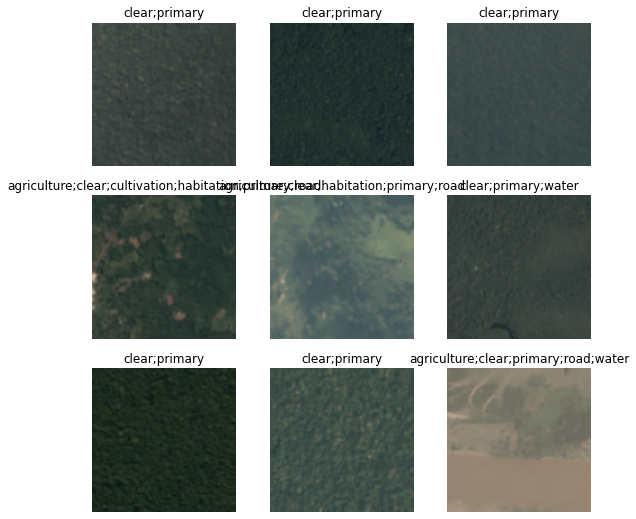

In [11]:
dls.show_batch()

<h2>Train & Save ResNet-50 Model</h2>

In [12]:
metrics = [partial(accuracy_multi, thresh=0.2), FBetaMulti(beta=2, average='samples', thresh=0.2)]
cbs = [MixUp]

In [13]:
learn = vision_learner(dls, resnet50, metrics=metrics)

SuggestedLRs(valley=0.0014454397605732083)

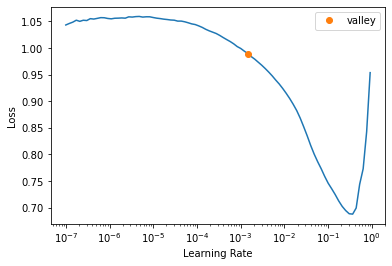

In [14]:
learn.lr_find()

In [15]:
learn.fine_tune(6, base_lr=2e-2, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,time
0,0.318217,0.129683,0.945871,0.889073,50:56
1,0.141781,0.109331,0.950267,0.903784,46:17
2,0.114119,0.102013,0.941903,0.909087,46:17
3,0.104233,0.099551,0.948494,0.912174,46:13


epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,time
0,0.099000,0.100268,0.953057,0.915812,55:47
1,0.099293,0.100777,0.952055,0.911424,55:42
2,0.093762,0.089678,0.951364,0.921798,55:43
3,0.088091,0.088716,0.956269,0.921220,55:44
4,0.080956,0.084226,0.958188,0.925799,55:44
5,0.076802,0.083985,0.959067,0.927016,55:40


In [16]:
learning_rate = 0.02
learn.fit_one_cycle(5, slice(learning_rate))

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,time
0,0.097055,0.168398,0.934520,0.847502,55:40
1,0.105549,0.107863,0.944388,0.903422,59:29
2,0.098669,0.095769,0.953712,0.914455,59:04
3,0.089302,0.088523,0.958173,0.923949,55:40
4,0.082207,0.084720,0.957795,0.926600,55:37


In [17]:
learn.save('resnet50-128')

Path('models/resnet50-128.pth')

<h2>Results of the Model</h2>

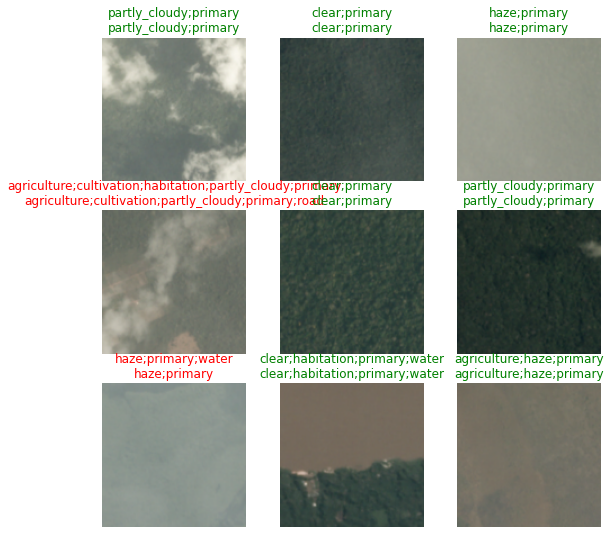

In [18]:
learn.show_results()

<h2>Prediction and Inference of the Model</h2>

In [19]:
learn.export() # if we want .pkl file for proper end to end deployment (file will be saved as export.pkl)

In [20]:
#inference = learn.load('resnet50-128')

In [21]:
additional_test_path = Path(r'D:\python_projects\Deforestation\input\test-jpg-additional')
test_path = Path(r'D:\python_projects\Deforestation\input\test-jpg')
submission_df = pd.read_csv(path/'sample_submission.csv')
testing_path = (submission_df['image_name'] + '.jpg').apply(lambda x: test_path/x if x.startswith('test') else additional_test_path/x)

def prediction(filename='submission.csv', tta=False):
    tst_dl = learn.dls.test_dl(testing_path)
    if tta:
        predictions = learn.tta(dl = tst_dl)
    else:
        predictions = learn.get_preds(dl = tst_dl)
    predlist = [' '.join(learn.dls.vocab[i]) for i in (predictions[0] > 0.2)]

    df = submission_df
    df['tags'] = predlist

    df.to_csv(filename, index=False)
    return df

In [22]:
prediction('submission_tta.csv', tta=True)

,image_name,tags
0,test_0,clear primary
1,test_1,clear primary
2,test_2,partly_cloudy primary
3,test_3,agriculture clear cultivation primary
4,test_4,partly_cloudy primary
...,...,...
61186,file_9995,cloudy partly_cloudy primary
61187,file_9996,clear primary water
61188,file_9997,clear primary road water
61189,file_9998,cloudy


In [27]:
test_path = Path(r'D:\python_projects\Deforestation\prediction\output')
submission_df = pd.read_csv(path/'submission_new.csv')
testing_path = (submission_df['image_name'] + '.tif').apply(lambda x: test_path/x if x.startswith('test') else additional_test_path/x)

def prediction(filename='submission.csv', tta=False):
    tst_dl = learn.dls.test_dl(testing_path)
    if tta:
        predictions = learn.tta(dl = tst_dl)
    else:
        predictions = learn.get_preds(dl = tst_dl)
    predlist = [' '.join(learn.dls.vocab[i]) for i in (predictions[0] > 0.2)]

    df = submission_df
    df['tags'] = predlist

    df.to_csv(filename, index=False)
    return df

prediction('submission_tta_2.csv', tta=True)

,image_name,tags
0,test_0,clear primary water
1,test_1,agriculture clear haze primary
2,test_2,agriculture clear primary road water
3,test_3,clear primary
4,test_4,clear primary
...,...,...
469,test_469,clear primary water
470,test_470,clear primary water
471,test_471,agriculture clear partly_cloudy primary
472,test_472,clear primary
